Библиотеки, которые используются в решении:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import time
%matplotlib inline

### Стыров Даниил, 307 группа.

# Практическое задание №1 по ОММ 
# Вариант №28


## Постановка задачи
Используя схему бегущего счета и итерационные методы, решить задачу:

$$
\left\{ \begin{array}{} \frac{\partial u}{\partial t} - \frac{2 u}{1 + u^{2}} 
        \frac{\partial u}{\partial x} = 0, \quad  -1 \leq x < 0, \\ u(x,0) = \cos{\frac{\pi x}{2}}, \\
    u(0,t) = 1 + \frac{1}{2} arctg\ t. \end{array} \right.
$$

## Построение характеристик

Характеристики квазилинейного уравнения переноса определяются следующими соотношениями:

$$\left\{ \begin{array}{} \frac{dt}{1}=\frac{dx}{-\frac{2u}{1+u^2}}, \\ du=0. \end{array} \right.$$

Проинтегрировав оба уравнения, получим:

$$\left\{ \begin{array}{} t-t^* = -\frac{1+u^{*2}}{2u^*} (x-x^*), \\ u=u^*=u^*(x^*,t^*). \end{array} \right.$$

Получим два семейства кривых, воспользовавшись начальным и граничным условиями:

$1. \quad t^*=0:$

$$\left\{ \begin{array}{} t=-\frac{1+(\cos{\frac{\pi x^*}{2}})^2}{2 \cos{\frac{\pi x^*}{2}}}  (x-x^*),,  \\ u^*=\cos{\frac{\pi x^*}{2}}. \end{array} \right.$$

$2. \quad x^*=0:$

$$\left\{ \begin{array}{} t=-\frac{1+(1+\frac{1}{2} arctg\ t^*)^2}{2+ arctg\ t^*}  x,  \\ u^*=1+\frac{1}{2} arctg\ t^*. \end{array} \right.$$

### Код для построения характеристик

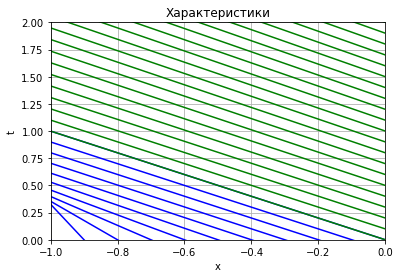

In [2]:
xmin =  -1
xmax = 0
tmin = 0
tmax = 2

def c1(x):
    return  [-(1 + (np.cos(np.pi * x0 * 0.5))*(np.cos(np.pi * x0 *0.5)))/(2 * (np.cos(np.pi*x0/2)))*(x-x0) for x0 in np.arange(xmin , xmax + 0.1, 0.1)]
def c2(x):
    return [t0 - (1 + (1 + 0.5 * np.arctan(t0)) * (1 + 0.5 * np.arctan(t0)))/(2 * (1 + 0.5 * np.arctan(t0))) * x for t0 in np.arange(tmin , tmax + 0.1, 0.1)]
    
x_arr = np.arange(xmin , xmax + 0.1, 0.1)
x_array = [c1(x) for x in  x_arr]
t_array = [c2(x) for x in  x_arr]

plt.plot()
plt.ylim(tmin , tmax)
plt.xlim(xmin , xmax)
plt.plot(x_arr , x_array , color = "blue")
plt.plot(x_arr , t_array , color = "green")
plt.title('Характеристики')
plt.ylabel('t')
plt.xlabel('x')
plt.grid(True)
plt.show()

Заметим, что в области $-1 \leq x < 0$ на промежутке времени $0 < t < 1$ характеристики не пересекаются. Будем искать решение в этой области во избежание опрокидывания волны.

## Разностная сетка

Введем в расчетной области равномерную сетку:

$$\omega_{h,\tau}=\big\{x_n=nh, t_m=m\tau, n=\overline{N-1,0}, m=\overline{0,M-1}\big\},$$

где $h = -\frac{1}{N-1}$, $\tau = \frac{1}{M-1}$ - шаги по координате и времени соответственно, $N,M$ - число узлов по осям $x$ и $t$ соответственно.

Перепишем исходное уравнение в дивергентном виде:

$$\frac{\partial u}{\partial t} +  
        \frac{\partial}{\partial x}(-\ln({1 + u^{2})}) = 0$$

Введем на $\overline{\omega_{h,\tau}}$ сеточную функцию: $y_n^m=u(x_n,t_m)$. Также удобно ввести вспомогательную функцию: $F_n^m=F(y_n^m)=-\ln(1+(y_n^m)^2)$

Для построения разностной схемы будем пользоваться трёхточечным шаблоном вида: 

<center><img src=https://i.imgur.com/YRr9TmA.png width="170"></center>

Для линейного уравнения переноса он является абсолютно устойчивым, а разностный оператор аппроксимирует дифференциальный с первым порядком точности $O(h+\tau)$. 

Разностная схема имеет следующий вид:

In [3]:
def F(u):
    return -np.log(1+u**2)

def dF(u):
    return -2*u/(1 + u**2)

def f(u, a, b):
    return (u - a)/τ + (F(u) - F(b))/h

def df(u):
    return 1/τ + dF(u)/h

def solve(a, b):
    result = b
    d = 1 + ε
    while(d > ε):
        y = result
        result = y - f(y, a, b)/df(y)
        d = np.abs(y - result)
    return result

In [4]:
N = 150     # число узлов вдоль оси x
M = 150     # число узлов по времни

x_min, x_max = -1, 0
t_min, t_max = 0, 1

h = -float(x_max - x_min)/(N - 1)    # шаг вдоль оси x
τ = float(t_max - t_min)/(M - 1)     # шаг по времени
ε = 1e-6                             # точность

u = np.zeros((N, M), dtype=float)
x = np.linspace(x_min, x_max, N)
t = np.linspace(t_min, t_max, M)

# ГУ и НУ
u[N-1, :] = 1 + 0.5*np.arctan(t)
u[:, 0] = np.cos(np.pi*x/2)

In [5]:
start = time.time()
for i in range(N-2, -1, -1):
    for j in range(1, M):
        u[i, j] = solve(u[i, j-1], u[i+1, j])
end = time.time()
print('Время вычисления', np.round(end - start, 3))

Время вычисления 0.52


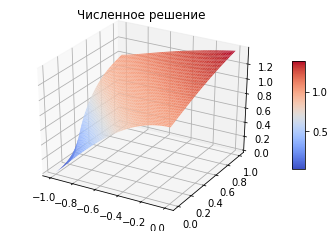

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
tm, xm = np.meshgrid(t, x)
surf = ax.plot_surface(xm, tm, u, cmap='coolwarm')
plt.title('Численное решение')
fig.colorbar(surf, shrink=0.5, aspect=8)

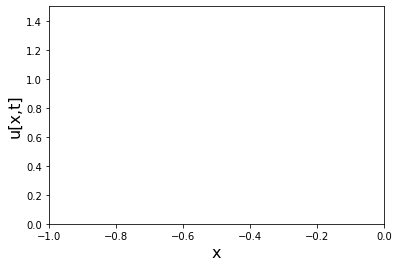

In [32]:
fig = plt.figure()
ax = plt.axes(xlim=(-1, 0), ylim=(0, 1.5))
plt.xlabel('x', fontsize=16)
plt.ylabel('u[x,t]', fontsize=16)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([],[])
    return line,

def animate(i):
    global x, u
    line.set_data(x, u[i, :])
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [ ]:


line = ax.plot(x, u[..., 0])[0]

def init():
    line.set_ydata([np.nan]*len(x))
    return line,

def animate(i):
    line.set_ydata(u[..., i])
    return line,
# animate=True
anim = animation.FuncAnimation(fig, animate, interval=10, init_func=init,
                               frames=100, blit=True)
# writervideo = animation.FFMpegWriter(fps=60)
# fig.show()

In [ ]:
N = 500
x1 = np.linspace(-1, 0, N)

def t1(x,c):
    return c/(-2*np.sin(np.pi*c/2)*np.exp(-(np.sin(np.pi*c/2))**2)) + x/(2*np.sin(np.pi*c/2)*np.exp(-(np.sin(np.pi*c/2))**2))

fig = plt.figure()
ax = fig.gca()

for i in range(1, N):
    ax.plot(x1, t1(x1, x1[i]))

ax.set_ylim(0, 2)